# Análise de e-mails recebidos

### Dados coletados via GMail
Extração 22/04/2025


In [101]:
#Importação e Pré-processamento
import mailbox
import pandas as pd
from tqdm import tqdm
from email.header import decode_header
import re

#Decodificar headers
def decode_maybe_encoded(header_value):
    if not header_value:
        return ''
    decoded_fragments = decode_header(header_value)
    return ''.join(
        part.decode(encoding or 'utf-8', errors='ignore') if isinstance(part, bytes) else part
        for part, encoding in decoded_fragments
    )

#Extrair body
def get_email_body(msg):
    try:
        if msg.is_multipart():
            for part in msg.walk():
                content_type = part.get_content_type()
                content_disposition = str(part.get("Content-Disposition"))
                if content_type == "text/plain" and "attachment" not in content_disposition:
                    body = part.get_payload(decode=True)
                    return body.decode(part.get_content_charset() or 'utf-8', errors='ignore')
        else:
            body = msg.get_payload(decode=True)
            return body.decode(msg.get_content_charset() or 'utf-8', errors='ignore') if body else ''
    except Exception as e:
        return ''
    return ''

#Leitura do MBOX
mbox = mailbox.mbox('Caixa de entrada-001.mbox')  # Substitua pelo nome do seu arquivo
data = []

for msg in tqdm(mbox, desc='Lendo e-mails'):
    try:
        subject = decode_maybe_encoded(msg['subject'])
        from_ = decode_maybe_encoded(msg['from'])
        date = decode_maybe_encoded(msg['date'])
        body = get_email_body(msg)
        data.append([from_, subject, body, date])
    except Exception as e:
        continue

df = pd.DataFrame(data, columns=['from', 'subject', 'body', 'date'])



Lendo e-mails: 100%|██████████| 34307/34307 [01:24<00:00, 405.12it/s]


In [102]:
#Pós-processamento
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # remover HTML
    text = re.sub(r'http\S+', '', text)  # remover links
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # letras apenas
    tokens = [word for word in text.split() if word not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)

#Criar campo com texto unificado e limpo
df['clean_text'] = (df['subject'].fillna('') + ' ' + df['body'].fillna('')).map(clean_text)


In [103]:
#Tamanho da base
df.shape


(34057, 5)

In [104]:
#Função para contar remetente
def extract_email(sender):
    email = re.search(r'<(.+?)>', sender)
    return email.group(1) if email else sender.strip()

df['clean_sender'] = df['from'].map(extract_email)
df['clean_sender']

0        jobalerts-noreply@linkedin.com
1              invitations@linkedin.com
2                       99pay@99app.com
3              promotion@aliexpress.com
4             voegol@news.voegol.com.br
                      ...              
34052        jobs-listings@linkedin.com
34053                noreply@github.com
34054      lovers@mail.cacaushow.com.br
34055         google-noreply@google.com
34056     ofertas@a.mercadolivre.com.br
Name: clean_sender, Length: 34057, dtype: object

In [105]:
#Contagem de envios
sender_counts = df['clean_sender'].value_counts()


In [106]:
#Função para extrair o termo entre "@" e "."
def extract_domain(sender):
    match = re.search(r'@([a-zA-Z0-9\-]+)\.', sender)
    return match.group(1) if match else None

# Criar a nova coluna
df['email_domain'] = df['clean_sender'].map(extract_domain)

In [107]:
#Contar quantas vezes cada domínio aparece
domain_counts = df['email_domain'].value_counts()

#Criar nova coluna com essa contagem
df['domain_count'] = df['email_domain'].map(domain_counts)


In [108]:
#Tabela com a contagem
df[['domain_count','email_domain']]

,domain_count,email_domain
0,5790,linkedin
1,5790,linkedin
2,294,99app
3,33,aliexpress
4,98,news
...,...,...
34052,5790,linkedin
34053,22,github
34054,936,mail
34055,233,google


In [109]:
#Padronizar a coluna: tudo minúsculo e remover espaços
df['email_domain'] = df['email_domain'].str.lower().str.strip()

#Recontar os domínios
domain_counts = df['email_domain'].value_counts()

#Atualizar a coluna com a contagem correta
df['domain_count'] = df['email_domain'].map(domain_counts)

df_domain_freq = df[['email_domain', 'domain_count']].drop_duplicates()
dupes = df_domain_freq[df_domain_freq.duplicated(subset='email_domain', keep=False)]
print(dupes)


Empty DataFrame
Columns: [email_domain, domain_count]
Index: []


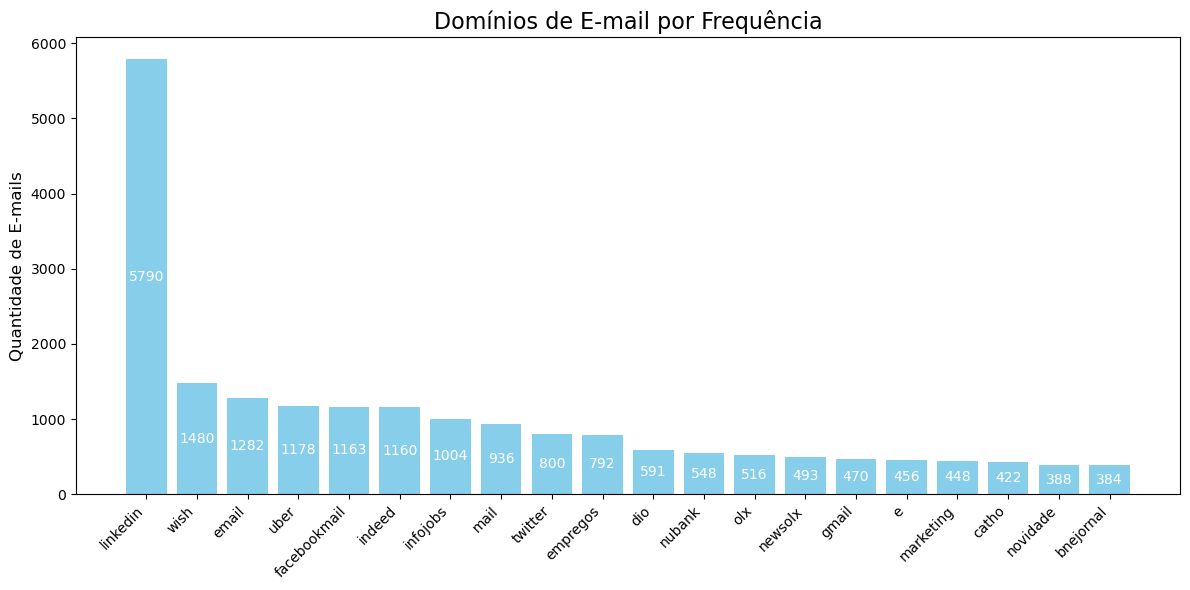

In [110]:
#Plotando o gráfico de barras
import matplotlib.pyplot as plt

#Selecionar e preparar os dados
df_domain_freq = df[['email_domain', 'domain_count']].drop_duplicates()
df_domain_freq = df_domain_freq.sort_values(by='domain_count', ascending=False)

#Limitar aos 20 principais
top_n = 20
df_plot = df_domain_freq.head(top_n)

# Criar gráfico
plt.figure(figsize=(12, 6))
bars = plt.bar(df_plot['email_domain'], df_plot['domain_count'], color='skyblue')

# Título e rótulos
plt.title('Domínios de E-mail por Frequência', fontsize=16)
plt.xlabel('')
plt.ylabel('Quantidade de E-mails', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#Adicionar os valores acima das barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,     # Centraliza no eixo X
        height / 2,                            # Coloca no meio da barra (eixo Y)
        f'{int(height)}',                      # Valor
        ha='center', va='center',              # Alinhamento horizontal e vertical
        fontsize=10, color='white'             # Branco para melhor contraste
    )

plt.show()


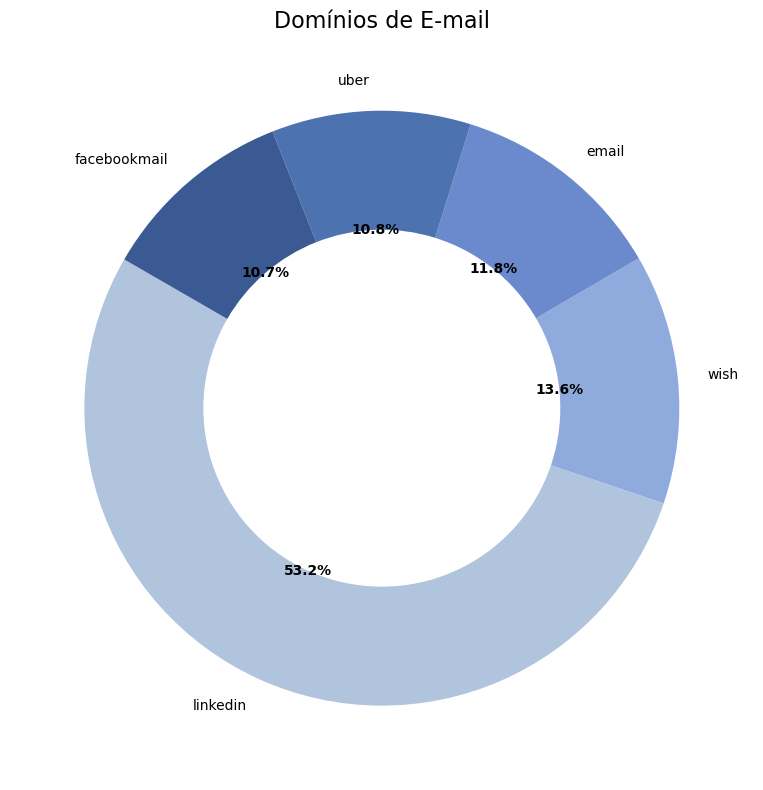

In [111]:
# Plotando gráfico de rosca
df_domain_freq = df[['email_domain', 'domain_count']].drop_duplicates()
df_domain_freq = df_domain_freq.sort_values(by='domain_count', ascending=False).head(5)

# Dados do gráfico
labels = df_domain_freq['email_domain']
sizes = df_domain_freq['domain_count']

# Paleta de cores
colors = ['#B0C4DE', '#8FAADC', '#6A8ACD', '#4C72B0', '#3B5A93']

# Criar gráfico de rosca
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,  # aplica as cores aqui
    autopct='%1.1f%%',
    startangle=150,
    wedgeprops=dict(width=0.4),
    textprops=dict(color='black')
)

# Título e estilo
ax.set_title('Domínios de E-mail', fontsize=16)
plt.setp(autotexts, size=10, weight='bold')
plt.tight_layout()
plt.show()
